# Plot classification performace (step 3)

In [108]:
import dask.dataframe as ddf
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from scipy import stats

from Metrics import ir_metrics

BASE_PATH = "/Users/erotundo/PycharmProjects/DatasetAnnotatorProj/Analysis/Data/travel/"
PRED_PATH = BASE_PATH + "predictions_threads_acceptedOnly_ansCountGte2_binaryBestAnswer/"


# plotting settings
sns.set(style="white", palette="muted", color_codes=True)
PLOTS_PATH = 'output/travel/'
PLOTS_FORMATS = ['.pdf', '.png']

In [109]:
def ndcg_at_k(df, k):
        return ir_metrics.ndcg_at_k(df['y_pred'], k)

def ndcg_at_k_post(df, k):
        return ir_metrics.ndcg_at_k(df['y_pred_post'], k)

def mrr(df):
    return ir_metrics.mean_reciprocal_rank(df['y_pred'])

def precision_at_k(df, k):
        return ir_metrics.precision_at_k(df['y_pred'], k)
    
def precision_at_k_post(df, k):
        return ir_metrics.precision_at_k(df['y_pred_post'], k)

In [110]:
mean_ndcg_data = dict()
ci_ndcg_data = dict()
mean_ndcg_post_data = dict()
ci_ndcg_post_data = dict()
mean_mrr_data = dict()
ci_mrr_data = dict()

    
for file_name in glob.glob(PRED_PATH + "*.csv"):
    model_name = file_name.split("/")[-1].split("_")[0]
    
    # init
    mean_ndcg_data[model_name] = []
    mean_ndcg_post_data[model_name] = []
    mean_mrr_data[model_name] = []
    ci_ndcg_data[model_name] = []
    ci_ndcg_post_data[model_name] = []
    ci_mrr_data[model_name] = []
    
    grouped_threads_df = pd.read_csv(file_name).groupby('thread_id')
    for k in xrange(1, 11):
        mean_ndcg_data[model_name].append(grouped_threads_df.apply(ndcg_at_k, k).mean())
        mean_ndcg_post_data[model_name].append(grouped_threads_df.apply(ndcg_at_k_post, k).mean())
        mean_mrr_data[model_name].append(grouped_threads_df.apply(mrr).mean())

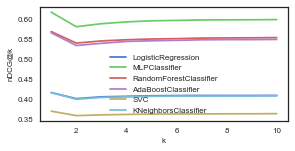

In [111]:
# normal predictions

fig = plt.figure(figsize=(4, 2))
ax1 = fig.add_subplot(111)

for model_name in mean_ndcg_data.keys():
    ax1.plot(range(1,11), 
             mean_ndcg_data[model_name], 
             label=model_name)

plt.xlabel('k', fontsize=8)
plt.ylabel('nDCG@k', fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)

plt.grid(alpha=0.0, linestyle='dotted')
plt.legend(fontsize=8)
plt.tight_layout(pad=0.3)

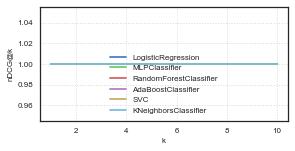

In [112]:
# post-processed predictions

fig = plt.figure(figsize=(4, 2))
ax1 = fig.add_subplot(111)

for model_name in mean_ndcg_post_data.keys():
    ax1.errorbar(range(1,11), 
             mean_ndcg_post_data[model_name], 
             label=model_name)

plt.xlabel('k', fontsize=8)
plt.ylabel('nDCG@k', fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)

plt.grid(alpha=0.7, linestyle='dotted')
plt.legend(fontsize=8)
plt.tight_layout(pad=0.3)

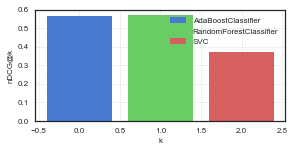

In [113]:
fig = plt.figure(figsize=(4, 2))
ax1 = fig.add_subplot(111)

ax1.bar(0,  mean_ndcg_data['AdaBoostClassifier'][0],  label='AdaBoostClassifier')
ax1.bar(1,  mean_ndcg_data['RandomForestClassifier'][0],  label='RandomForestClassifier')
ax1.bar(2,  mean_ndcg_data['SVC'][0],  label='SVC')

plt.xlabel('k', fontsize=8)
plt.ylabel('nDCG@k', fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)

plt.grid(alpha=0.7, linestyle='dotted')
plt.legend(fontsize=8)
plt.tight_layout(pad=0.3)


## Featues importance (RF)

In [ ]:
# TODO

## GridSearchCV analysis

In [ ]:
# TODO